# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [ ]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # Visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

In [ ]:
import os
import cv2 #Import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2. Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [ ]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
This Segmenatation Model is based on U-Net.
The codes are based on: https://github.com/MrGiovanni/ModelsGenesis/blob/master/pytorch/unet3d.py
"""

class ContBatchNorm2d(nn.modules.batchnorm._BatchNorm):

    def forward(self, input):
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm2d(out_chan)

        if act == 'ReLU':
            self.activation = nn.ReLU()
        elif act == 'PReLU':
            self.activation = nn.PReLU()
        elif act == 'LeakyReLU':
            self.activation = nn.LeakyReLU()
        elif act == 'ELU':
            self.activation = nn.ELU(inplace=True)
        elif act == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out


def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)


class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth, act)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x, mid_layer=False):
        if mid_layer:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

    
class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth, act):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose2d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans + outChans//2, depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv2d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

    
class CNNSEG(nn.Module): # Define your model
    def __init__(self, n_class=4, act='ReLU'):
        super(CNNSEG, self).__init__()
        # fill in the constructor for your model here
        self.down_tr64 = DownTransition(1,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)
        # self.down_tr1024 = DownTransition(512,4,act)    # Adding another downsample layer
        
        # self.up_tr512 = UpTransition(1024,1024,3,act)   # Adding another upsample layer
        self.up_tr256 = UpTransition(512,512,2,act)
        self.up_tr128 = UpTransition(256,256,1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64, n_class)
        
    def forward(self, x):
        # fill in the forward function for your model here
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128, self.skip_out128 = self.down_tr128(self.out64)
        self.out256, self.skip_out256 = self.down_tr256(self.out128)
        self.out512, self.skip_out512 = self.down_tr512(self.out256, mid_layer=True)
        # self.out1024, self.skip_out1024 = self.down_tr1024(self.out512, mid_layer=True)  # Forward another downsample layer

        # self.out_up_512 = self.up_tr512(self.out1024, self.skip_out512)  # Forward another upsample layer
        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256, self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128, self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out

model = CNNSEG() # We can now create a model using your defined segmentation model

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [ ]:
"""
Loss function & optimizer
"""
import torch.optim as optim

"""
The code for the Tversky loss function are based on: https://github.com/JunMa11/SegLoss/blob/master/losses_pytorch/dice_loss.py
"""

def sum_tensor(inp, axes, keepdim=False):
    # copy from: https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/utilities/tensor_utilities.py
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp

def get_tp_fp_fn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes:
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2

    tp = sum_tensor(tp, axes, keepdim=False)
    fp = sum_tensor(fp, axes, keepdim=False)
    fn = sum_tensor(fn, axes, keepdim=False)

    return tp, fp, fn

class TverskyLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.,
                 square=False):
        """
        paper: https://arxiv.org/pdf/1706.05721.pdf
        """
        super(TverskyLoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth
        self.alpha = 0.61
        self.beta = 0.39

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)


        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                tversky = tversky[1:]
            else:
                tversky = tversky[:, 1:]
        tversky = tversky.mean()

        return 1-tversky

In [47]:
def get_loss_func(loss_name):
    if loss_name == "Tversky":
        return TverskyLoss()
    if loss_name == "CrossEntropy":
        return nn.CrossEntropyLoss()

def get_optimizer(model, method, learning_rate):
    if method == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif method == "Adam":
        return optim.AdamW(model.parameters(), lr=learning_rate)
    elif method == "AdaGrad":
        return optim.Adagrad(model.parameters(), lr=learning_rate)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [50]:
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train(model, num_workers = 0, batch_size = 4,epochs = 25,learning_rate = 1, optimizer_name = "Adam", 
          loss_name="Tversky", target=None):
    """
    This function takes a CNNSEG model, num_workers, batch size, epochs, learning rate, PyTorch optimizer,
    loss function, and a target performance for mean dice on the validation set. 
    
    It trains the model and updates its parameters. It also keeps track of the dice scores and loss on the 
    training set and validation set. 
    
    It plots the loss and mean dice of the training set and validation set for each epoch. 
    
    The function returns the final value of the dice score and loss in the validation set.
    """

    # Get Data Loader for Training Set
    data_path = './data/train'
    train_set = TrainDataset(data_path)
    training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, 
                                      shuffle=True,drop_last = True)

    # Get Loss Function and Optimizer
    loss_func = get_loss_func(loss_name)
    optimizer = get_optimizer(model, optimizer_name, learning_rate)

    # Initializes empty containers
    loss_list_train = list()
    loss_list_val = list()
    dice_list_train = list()
    dice_list_val = list()
    
    # Train the Model
    # Epoch loop
    for e in range(epochs):
        iteration_dice_list = list()
        
        # Iteration loop
        for iteration, sample in enumerate(training_data_loader):
            print("Epoch, Iteration:", e, iteration)
            
            # Fetch images and labels.  
            img, mask = sample
            
            # show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze())      # Visualise all data in training set
            # plt.pause(1)

            
            # Write your FORWARD below
            # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
            model.train()                                          # Set the model to training mode
            optimizer.zero_grad()                                  # Avoid accumulating gradients
            img = img / 255 - 0.5                                  # Normalization
            y_pred = model(img.reshape(batch_size,1,96,96))        # Forward pass
            
            
            # Then write your BACKWARD & OPTIMIZE below
            # Note: Compute Loss and Optimize
            loss = loss_func(y_pred , mask.long())                 # Compute Loss
            loss.backward()                                        # Calculate Gradients
            optimizer.step()                                       # Update Model's Params
            
            masks_pred = torch.argmax(y_pred, dim=1)               # Merge four channels into one channel
            iteration_dice = see_dice(mask.numpy(), masks_pred.squeeze().numpy())      # Compute Dice
            
            # Record the Loss and Dice of training set for each iteration
            iteration_dice_list.append(iteration_dice)
            loss_list_train.append(loss)
            print("Iteration Loss:",loss)
        
        # Record the Dice of training set for each epoch (Take the mean dice of each iteration)
        epoch_dice = np.mean(iteration_dice_list)
        dice_list_train.append(epoch_dice)
        print("Epoch Dice:", epoch_dice)
        
        # Evaluate by validation set
        val_dice, val_loss = evaluate(model, loss_func)
        loss_list_val.append(val_loss)
        dice_list_val.append(val_dice)
        
        # Check the validation dice with target dice
        if target:
            if val_dice > target:                                          # Find a desirable dice
                model_params_path = "net_params.pth"
                torch.save(model.state_dict(), model_params_path)          # Save the model
                print("The model parameters have been saved.")
                break
    
    # Plot Loss and Dice both in Training set and Validation set
    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=False, sharey=False, figsize=(12, 5))
    # Plot Loss
    X = (np.arange(len(loss_list_val))+1) * int(100/batch_size)
    axs[0].plot(loss_list_train, "b-", label=u"Training Loss")
    axs[0].plot(X, loss_list_val, "ro-", label=u"Validation Loss") 
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc="upper right")
    # Plot Dice 
    plot_text(dice_list_train, plt=axs[1])
    plot_text(dice_list_val, plt=axs[1])
    axs[1].plot(dice_list_train, "bo-", label=u"Training Dice")
    axs[1].plot(dice_list_val, "ro-", label=u"Validation Dice")
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Dice')
    axs[1].legend(loc="lower right")
    plt.suptitle('Comparing Loss and Dice', fontsize=16)
    plt.show()
    
    return dice_list_val[-1], loss_list_val[-1]

def plot_text(value_list, plt):                     # Add text values in plot
    for x,y in enumerate(value_list):
        if x % max(int(len(value_list)/5),1) == 0 or x == len(value_list)-1:
            plt.text(x, y, '%.3f' % y, fontdict={'fontsize':10})

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.

def test(model):
    """
    This function takes a CNNSEG model and then loads the parameters from a saved file.
    
    It tests the model on the unseen test data set, producing its PNG mask image and then 
    saving the images into a folder called test_results.
    
    This function returns the name of the folder. 
    """
    # Get Data Loader for Test Set
    data_path = './data/test'
    num_workers = 0
    batch_size = 2
    test_set = TestDataset(data_path)
    test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
    
    # Setting
    i_png = 120
    folder = './test_results'
    if not os.path.exists(folder):
        os.mkdir(folder)
    
    # Load saved model
    model_params_path = "net_params.pth"
    model.load_state_dict(torch.load(model_params_path))

    # Test Model
    with torch.no_grad():               # Fix the model's params
        model.eval()                    # Set model to evaluation mode

        for iteration, sample in enumerate(test_data_loader):
            img = sample                                          # Fetch images and labels

            # plt.imshow(img[0,...].squeeze(), cmap='gray')       # Visualise all images in test set
            # plt.pause(1)

            # Produce Segmentation Masks
            img = img / 255 - 0.5                                 # Normalization
            y_pred = model(img.reshape(batch_size,1,96,96))       # Forward pass
            masks = torch.argmax(y_pred, dim=1)                   # Merge four channels into one channel

            # Save png images
            masks = masks.squeeze()
            for mask in masks:
                i_png = i_png + 1
                cv2.imwrite(os.path.join(folder,'cmr%s_mask.png' % i_png), mask.numpy())
    
    print("Saved image successfully")
    return folder

## 3. Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [ ]:
# Compute the dice between two masks in 3 labels
def see_dice(mask1, mask2):
    dice_list = list()
    for i in range(1, 4):
        dice = categorical_dice(mask1, mask2, label_class=i)
        dice_list.append(dice)
    return np.mean(dice_list)

In [51]:
def evaluate(model, loss_func, num_workers = 0, imshow=False):
    """
    This function takes a CNNSEG model,loss function, num_workers,
    and a boolean value to show the prediction mask vs. the actual mask
    
    It evaluates the model on the validation set. It can plot the predicted mask and 
    show it next to the actual mask.
    
    The function returns the mean dice score and the loss on the validation set.
    """
    # Get Data Loader for Validation Set
    data_path = './data/val'
    val_set = TrainDataset(data_path)
    val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, shuffle=True)
    
    # Evaluate the model
    with torch.no_grad():               # Fix the model's params
        model.eval()                    # Set model to evaluation mode
        batch_dice_list = list()
        for iteration, sample in enumerate(val_data_loader):
            img, mask = sample                                   # Fetch images and labels
            img = img/255 - 0.5                                  # Normalization
            y_pred = model(img.reshape(1,1,96,96))               # Forward pass
            val_loss = loss_func(y_pred , mask.long())           # Compute validation loss
            masks = torch.argmax(y_pred, dim=1)                  # Merge four channels into one channel
            
            # Plot the true mask and the predicted mask
            if imshow:
                fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, sharey=True, figsize=(12, 5))
                axs[0].set_title("True Mask")
                axs[1].set_title("Predicted Mask")
                axs[0].imshow(mask.squeeze(), cmap='gray')
                axs[1].imshow(masks.squeeze(), cmap='gray')
                plt.show()
            
            # Record the dice for each iteration
            batch_dice = see_dice(mask.numpy(), masks.squeeze().numpy())       # Compute Dice
            batch_dice_list.append(batch_dice)
            print("Batch Dice:",batch_dice)

        # Record the dice of the entire validation set
        val_dice = np.mean(batch_dice_list)
        print("Validation Dice:",val_dice)
        
        return val_dice, val_loss

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [52]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

## 4. Experiments for Different Hyperparameters

In [54]:
import csv

"""
Choose Different Hyperparameters for testing the grid search. 
"""
# loss_name = 'CrossEntropy'
loss_name = 'Tversky'

# optimizer_name = 'SGD'
optimizer_name = 'Adam'
# optimizer_name = 'AdaGrad'

activation_name = 'ReLU'
# activation_name = 'Tanh'
# activation_name = 'LeakyReLU'

lr_search_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6] # learning rate list
batch_search_list = [1,2,4,8,16,32,64] # batch size list
epochs = 25
num_workers = 0
    
# Record the result into a CSV file
file_name = activation_name + "_" + loss_name + "_" + optimizer_name + '.csv'

"""
Do Experiments with Different Hyperparameters
"""
with open(file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Learning Rate", "Batch Size","Epochs","Loss Function", "Optimizer","Activation","Mean Dice","Validation Loss"])
    
    for lr in lr_search_list:
        print("Test for Learning Rate: ", lr)
        for batch in batch_search_list:
            print("Test for Batch Size: ", batch)
            
            # Initialize the model
            model = CNNSEG(act=activation_name)
            
            # Train the model and get the validation result
            meanDice, valLoss = train(
                model = model,
                num_workers = num_workers, 
                batch_size = batch,
                epochs = epochs,
                learning_rate = lr, 
                optimizer_name = optimizer_name,
                loss_name = loss_name
            )
            
            # Record the validation result 
            writer.writerow([lr, batch, epochs, loss_name, optimizer_name, activation_name, meanDice, valLoss])

Test for Learning Rate:  1
Test for Batch Size:  1


NameError: name 'CNNSEG' is not defined

## 5. Generate the Final Model to Submit

In [ ]:
# Step 1 - Set Best Hyperparameters
loss_name = 'Tversky'
optimizer_name = 'Adam'
activation_name = 'ReLU'
learning_rate = 0.0001
batch_size = 1
epochs = 25
num_workers = 0
model = CNNSEG(act=activation_name)

In [ ]:
# Step 2 - Train the Model
model_para_path = train(
    model = model, 
    num_workers = num_workers, 
    batch_size = batch_size,
    epochs = epochs,
    learning_rate = learning_rate, 
    optimizer_name = optimizer_name, 
    loss_name= loss_name, 
    target=0.89
)

In [ ]:
# Step 3 - Visualise Prediction in Validation Set
model_params_path = "net_params.pth"
model.load_state_dict(torch.load(model_params_path))
evaluate(model, get_loss_func(loss_name), imshow=True)

In [ ]:
# Step 4 - Implement on Test Set
folder = test(model)

# Generate CSV file
submission_converter(folder, './')
print("Generate CSV file successfully")

# Report for Cardiac MR Image Segmentation

In this report we will describe our approach to semantic segmentation of cardiovascular magnetic resonance (CMR) images using deep learning. We will discuss our implementation of our neural network, our experimentation to optimize network’s generalization performance, and present our final model.

# Introduction

To perform our task of semantic segmentation, we will use a convolutional neural network (CNN), a type of deep learning. CNNs have been gaining momentum within the field of computer vision, as clearly shown by one of the most cited papers in this area [Krizhevsky et al., 2017]. Within computer vision, image segmentation has applications in many different fields such as pattern recognition, image compression, and image retrieval [Wang, 2010].

We will create a CNN that will segment CMR images allowing additional information to be processed by mapping each pixel to a particular label to create regions within the image, yielding a segmented mask image [Tamilselvan and Murugesan, 2018]. In particular in CMR images, we will split images into the background region, the left ventricle (LV) region, the myocardium (Myo) region and the right ventricle (RV) region. From this, information such as the myocardial mass, wall thickness, left and right ventricle volumes can be extracted, which is important for diagnosing cardiovascular diseases [Chen et al., 2020].

The data sets that we will use for creating and testing our model will be from the Automated Cardiac Diagnosis Challenge (ACDC). The dataset provided in the coursework has been modified and has 200 CMR images. The data has been divided into training (50%), validation (10%), and test (40%) sets. We will use the training set to learn the parameters and the validation set for experiments to find hyperparameters that optimize performance. Finally, we will use our best performing models from our training and validation sets to test on Kaggle to see performance on unseen test data.

# Implementation

We decided to implement a U-Net architecture. We note that fully convolutional deep neural networks (FCNs) are excellent at image segmentation [Salehi et al., 2017], however the U-Net architecture we used is designed as an improvement on FCN architectures [Gadosey et al., 2020] specifically for image segmentation on biomedical datasets [Wang et al., 2020]. Our problem deals with biomedical data, thus making U-Net a good choice. We also chose to implement the U-Net architecture due to its ability to perform the segmentation of the data with a small amount of labeled data [Gadosey et al., 2020]. Since we only have 100 CMR images as training data we decided the U-Net architecture is a good network to implement.

To implement the U-Net architecture we modified a PyTorch implementation from the ModelsGensis repository on GitHub (linked in code). Their implementation was designed for three dimensional images. We modified their code to fit our problem with two dimensional images. Additionally, we generalised their classes for our hyperparameter testing. For example, we expanded the selection of activation functions that can be chosen for training by adding Leaky ReLu and hyperbolic tangent. We also had to fit their classes to the provided CNNSEG class.

We implemented Cross Entropy via PyTorch. We wanted to add another loss funciton so we used Tversky loss due to its ability to weigh the contributions of the false positives and false negatives, via additional hyperparameters, to the loss respectively [Salehi et al., 2017]. With this we attempt a better generalisation by accounting for this bias [MathWorks, 2020]. To implement Tversky loss, we used a PyTorch implementation from the SegLoss repository on GitHub (link in code). Again, we modified their code slightly to fit our problem.

We decided to use the dice score to evaluate the quality of the predicted masks. We added a function named see  dice() that would compute the dice between two masks that would use the categorical dice function that was given.
We implemented a function that would train the model. This function would take all of the hyperparametersincluding the optimiser and loss function as arguments. We keep track of the loss and dice scores for the training and validation sets, where we append the losses and dice scores after each epoch. Within each epoch we set the model for training, set the gradient equal to 0, and the predict on the batch. We then calculate the loss on the prediction with respect to actual masks to then use PyTorch’s backward method for propagation. We use optimizer.step() to update the parameters. Finally, the function plots the loss and dice score for each epoch for the validation and training set.

To tune hyperparameters we implemented an evaluate function that would take the trained model and evaluate it on the validation set. This would return the average dice score and loss across the validation sets. Here we would predict the masks for the validation set and then calculate the dice scores of the predicted masks vs. the true masks. Also the function plots the true mask and the predicted mask to compare side by side.

We created a test function that loads a saved model and then predicts the masks on all the data in the test set. This function produces each mask’s PNG image and then saves them into a folder.

We automated a grid search so that we have the performance metrics from our tests saved in CSV files for easier analysis. We created a naming scheme for each file based on the loss function, optimiser, and activation function chosen. Here we also define the values for the learning rates and batch sizes. The code will run every combination of the learning rates and batch sizes defined and then output the mean dice score on the validation set and the validation loss into the CSV.
In section 5 of the jupyter notebook, we implement all of the functions and classes that create the model, train it, test it, and produces the CSV that can uploaded to Kaggle.


#  Experiment
## Experiment Design

We designed our experiment to tune hyperparameters via a grid search on different types of loss functions, optimisers, and activation functions. The following loss functions were chosen: Cross Entropy and Tversky. The following optimisers were chosen: Stochastic Gradient Descent, Adam, and Adagrad. Finally, we tested on the following activation functions: ReLu, Leaky ReLu, and hyperbolic tangent. All combinations of loss functions, optimisers, and activation functions were tested resulting in 18 different combinations. A fixed value of 10 epochs were used initially. Each combination was tested with a grid search on various learning rates and batch sizes. Note, the training loss and validation loss were looked at to ensure no overfitting was occurring.

We measured performance of the tests with the mean dice on the validation set. We compared the best setting of learning rate and batch size for each combination. We then used the top 3 best performing models to be investigated further on 25 epochs. When then optimized the hyperparameters in the Tversky loss, the epochs, and the number of layers in the U-Net. 

We described the division of the data in the introduction. The training set was used to learn the parameters. The validation set was used to tune our hyperparameters. We then deploy the trained model and tuned hyperparameters of the best performing model on the validation set onto the test set to evaluate the performance of our model on unseen data. We ensure that we keep the test set as unseen data and let it not influence our settings for the hyperparameters as this will not longer be a fair evaluation of our model. We also ensured that our validation accuracy was around the same as the training accuracy so we were not overfitting the training set. This will mean that we have a model that generalises well when applied to the unseen test data set.


## Experiment Results

Initially, all possible combinations between the activation functions, optimisers, loss function - 18 in total - were tested with a fixed epochs value at 10. A grid search was then performed for the learning rate and batch size. For each model, the highest average dice value was taken to represent the performance of each, as shown in Figure 1. While we are aware that with higher epochs, all models would have performed better, due to the time limitation, it was decided to choose the ones with distinctly higher performance, even at fewer epochs. 

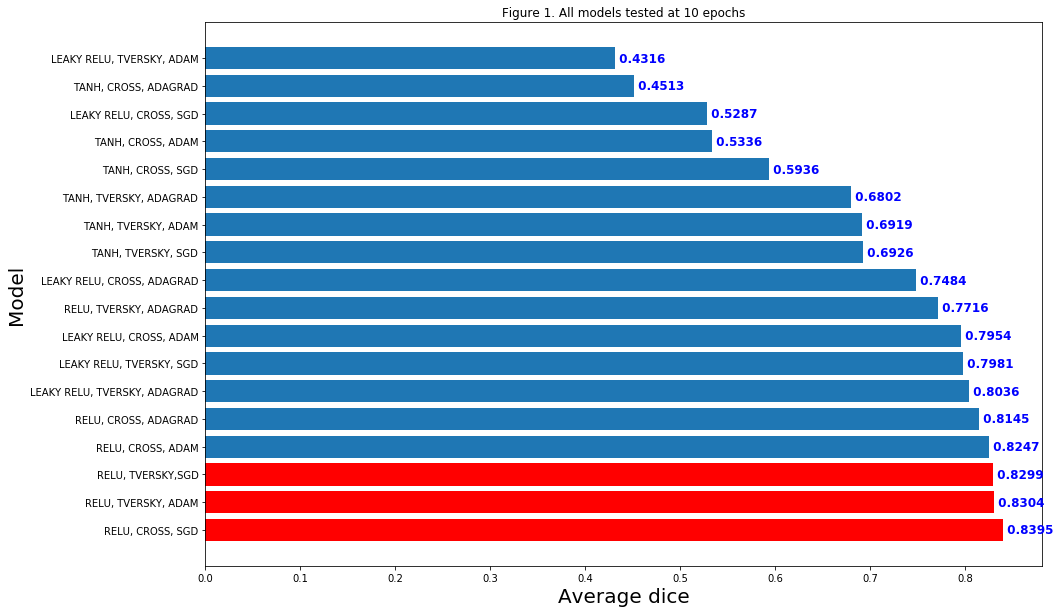

In [49]:
import matplotlib.pyplot as plt
import numpy as np

name_model = ['RELU, CROSS, SGD','RELU, TVERSKY, ADAM','RELU, TVERSKY,SGD','RELU, CROSS, ADAM',
              'RELU, CROSS, ADAGRAD','LEAKY RELU, TVERSKY, ADAGRAD','LEAKY RELU, TVERSKY, SGD',
              'LEAKY RELU, CROSS, ADAM','RELU, TVERSKY, ADAGRAD','LEAKY RELU, CROSS, ADAGRAD',
              'TANH, TVERSKY, SGD','TANH, TVERSKY, ADAM','TANH, TVERSKY, ADAGRAD','TANH, CROSS, SGD',
              'TANH, CROSS, ADAM','LEAKY RELU, CROSS, SGD','TANH, CROSS, ADAGRAD','LEAKY RELU, TVERSKY, ADAM']
dice_model = [0.8395,0.8304,0.8299,0.8247,0.8145,0.8036,0.7981,0.7954,0.7716,0.7484,0.6926,0.6919,
              0.6802,0.5936,0.5336,0.5287,0.4513,0.4316]

a = sorted(zip(dice_model, name_model), reverse=True)[:3]
name3 = []
dice3 = []
for i in a:
    name3.append(i[1])
    dice3.append(i[0])
dice_model= [round(num, 4) for num in dice_model]        
y_pos = np.arange(len(name_model))
plt.barh(y_pos,dice_model)
plt.barh(name3,dice3, color = 'red')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.yticks(y_pos, name_model)
plt.title('Figure 1. All models tested at 10 epochs')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.xlabel('Average dice', fontsize=20)
plt.ylabel('Model', fontsize=20)
for i, v in enumerate(dice_model):
   plt.text(v, i, " "+str(v), color='blue', va='center', fontweight='bold', fontsize = 12)

plt.show()

The best 3 models, with values above 0.825 in Figure 1, highlighted in red, were then tested at 25 epochs, with the results presented in Figure 2. These were tested with the learning rate and batch size hyperparameters fixed at the values from the previous grid search test. The best model was concluded to be the one constructed with Tversky loss function, ReLu activation function and the ADAM optimizer.

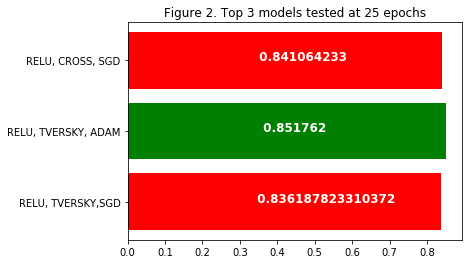

In [18]:
dice_25 = [0.836187823310372,0.851762,0.841064233]
name_25 = ['RELU, TVERSKY,SGD','RELU, TVERSKY, ADAM','RELU, CROSS, SGD']
y_pos = np.arange(len(name_25))
plt.barh(name_25,dice_25, color = 'red')
bestname = ['RELU, TVERSKY, ADAM']
bestmodel = [0.851762]
#fig = plt.gcf()
#fig.set_size_inches(15, 10)
plt.yticks(y_pos, name_25)
plt.barh(bestname,bestmodel, color = 'green')
plt.title('Figure 2. Top 3 models tested at 25 epochs')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
for i, v in enumerate(dice_25):
   plt.text(v-0.5, i, " "+str(v), color='white', va='baseline', fontweight='bold', fontsize = 12)


Now that we have found our best model we will look at how we tuned the hyperparamters for it. Below we will summarise our experiments ran on Tversky loss, learning rate, batch size, number of hidden layers, and epochs.

### Tversky Loss Hyperparameter Optimisation for Final Model

We can improve generalisation by optimising the hyperparameters of α and β of our Tversky loss function as we can improve the correction for any data imbalance. We began by maintaining all other hyperparameters for our chosen model and then randomly picking values for α (thus β since β = 1 - α) and observes the mean dice of our U-Net model. In other words, random search was used to find lower and upper bounds of the mean dice of our model and tests were run on the mid-point of this interval to find a smaller interval. We repeated this test several times. We choose to find α and β to 2 decimal places. From our experiements, we obtained the following plot.

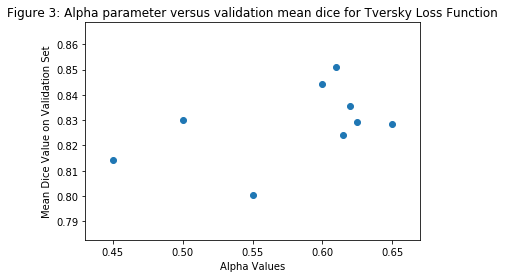

In [19]:
alpha = [0.6,0.5,0.55,0.45,0.65,0.625,0.61,0.62,0.615]
val_dice= [0.8441529549708736,0.8302270767106243,0.8003967305709455,
           0.8143681083489538, 0.8283610074542992,0.8292482370261751,0.8509846872222309,
           0.8356568355603958, 0.8243151270690395]

plt.scatter(alpha,val_dice)
plt.xlabel("Alpha Values")
plt.ylabel("Mean Dice Value on Validation Set")
plt.title("Figure 3: Alpha parameter versus validation mean dice for Tversky Loss Function")
plt.show()

We can see here that the optimal value for α is 0.61 since it had the highest mean dice value. Thus, when we implement Tversky in subsequent tests, we choose α = 0.61 and β = 0.39.

### Learning Rate for Final Model

For the final model chosen a smaller learning rate performed better than a higher one. In the graph below it can be seen that between a range of 0.0001 and 0.1 this relationship holds. A learning rate of 0.0001 was optimal. These results are from the grid search carried out as explained in the experiment design for 10 epochs. 

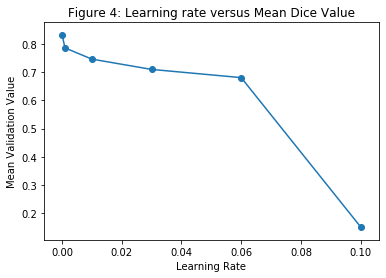

In [38]:
lr = [0.1,0.06,0.03,0.01,0.001,0.0001]
diceval = [0.151861317,0.680181094,0.709218579,0.745676491,0.785405996,0.830392059]

plt.plot(lr,diceval)
plt.scatter(lr,diceval)
plt.title('Figure 4: Learning rate versus Mean Dice Value')
plt.xlabel("Learning Rate")
plt.ylabel("Mean Validation Value")
plt.show()

### Batch Size for the Final Model

Similarly, a smaller batch size for the final model also performed better than a higher one. This held true for a range between 1 and 32. A batch size of 1 was optimal.

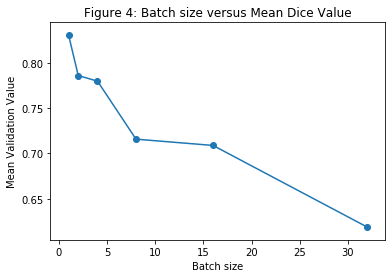

In [46]:
batchsize = [32,16,8,4,2,1]
dice = [0.618944308,0.708837118,0.715764975,0.779700757,0.785867825,0.830392059]

plt.plot(batchsize,dice)
plt.scatter(batchsize,dice)
plt.title('Figure 4: Batch size versus Mean Dice Value')
plt.xlabel("Batch size")
plt.ylabel("Mean Validation Value")
plt.show()

### Number of Hidden Layers in the Final Model

### Epochs

With our chosen model and optimised hyperparameters, we can now begin testing on the number of epochs the model is trained on. If we set our target accuracy to be 0.85, we obtain the following graph.

![jupyter](./epochsgraph.png)

We can see that if we run at higher epochs, whilst our accuracy may be increasing, it is becoming saturated so there is little improvement beyond this for much more computational cost. We begin to overfit after 5 epochs, however, our mean dice continues to increase which suggests that it will eventually converge at larger epochs. This is further demonstrated by the training mean dice at the last 3 points becoming saturated whereas the validation mean dice is continuing to increase. We now test the performance of our model on the validation set at increments of 10 epochs and obtain the following graph.

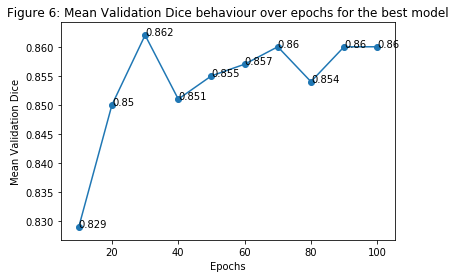

In [57]:
epochs = np.arange(10,110,10)
dice = [0.829343046,0.849977531,0.861602669,0.8507335359999999,0.85527379,0.857457348,0.859868482,0.8537203109999999,0.8601064490000001,0.859590823]
diceuse = [round(num, 3) for num in dice]
plt.plot(epochs,diceuse)
plt.scatter(epochs,diceuse)
ax = plt.gca()
ax.set_xlabel("Epochs")
ax.set_ylabel('Mean Validation Dice')
plt.title('Figure 6: Mean Validation Dice behaviour over epochs for the best model')
for i, txt in enumerate(diceuse):
    ax.annotate(txt, (epochs[i], diceuse[i]))



Here we can see that the mean dice values for 30, 90 and 100 epochs are very similar, suggesting that again mean dice is becoming saturated at larger epochs. Therefore, whilst we can obtain a good model with 30 epochs, should we have the time and computational resources, we could run at larger epochs to obtain a marginally better model however this quickly becomes very expensive.

## Conclusion